In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import LabelBinarizer
import cv2

In [2]:
import os
labels = ['DROWSY', 'NATURAL']
img_size = 150
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data,dtype=object)

In [3]:
test = get_training_data(r'Drowsy_datset\test')
train = get_training_data(r'Drowsy_datset\train')

In [4]:
from sklearn.preprocessing import LabelEncoder
#Train Test Split
x_train = []
y_train = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)


# Normalize the data
x_train = np.stack([x_train]*3, axis=-1)  # Adds channel dimension and replicates grayscale to RGB (150, 150) -> (150, 150, 3)
x_test = np.stack([x_test]*3, axis=-1)    # Same for test data

# Convert lists to numpy arrays and normalize the data
x_train = np.array(x_train) / 255.0
x_test = np.array(x_test) / 255.0

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)
label_encoder = LabelEncoder()

# Fit the label encoder on the training labels and transform both training and test labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_val_encoded = label_encoder.transform(y_val)

y_train = np.array(y_train_encoded)
y_test = np.array(y_test_encoded)
y_val = np.array(y_val_encoded)

In [5]:
# Data augmentation
"""
Please remove the comments as you see fit but with the last 5 parameters the training accuracy becomes way lower than validation accuracy
as the dataset becomes harder for the model to learn
"""
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        # zoom_range = 0.2, # Randomly zoom image
        # width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        # height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        # horizontal_flip = True,  # randomly flip images
        # vertical_flip=False # randomly flip images
        )


datagen.fit(x_train)

In [11]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn import svm
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report
modelSVM= SVC(C=1.0,
              kernel='rbf',
              gamma='scale',
              shrinking=True,
              probability=False,
              tol=0.005,
              cache_size=200,
              class_weight=None,
              verbose=False,
              max_iter=-1,
              decision_function_shape='ovr',
              break_ties=False,
              random_state=None)
x_train_flattened = x_train.reshape(x_train.shape[0], -1)

# Train the SVC model
modelSVM.fit(x_train_flattened, y_train)
x_test_flattened = x_test.reshape(x_test.shape[0], -1)

# Make predictions
y_pred = modelSVM.predict(x_test_flattened)

# Calculate accuracy
accuracy = accuracy_score(y_pred, y_test)
print(f"The model is {accuracy*100}% accurate")


The model is 84.8954821308159% accurate


In [12]:
import pickle

# save
with open('model.pkl','wb') as f:
    pickle.dump(modelSVM,f)


In [23]:
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard

In [17]:
model = Sequential()

    # Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150,150,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
# Flatten layer
model.add(Flatten())

# Dense layers
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))

# Output layer
model.add(layers.Dense(len(labels), activation='softmax'))
model.compile(optimizer=Adam(learning_rate=0.00001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

ResourceExhaustedError: {{function_node __wrapped__StatelessRandomUniformV2_device_/job:localhost/replica:0/task:0/device:CPU:0}} OOM when allocating tensor with shape[5161984,256] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu [Op:StatelessRandomUniformV2] name: 

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=10, min_lr=1e-7, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_cnn_mazen.h5', monitor='val_loss', save_best_only=True, verbose=1)

batch_size = 32
epochs = 10


history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train) // batch_size,
                    validation_data=(x_val, y_val),
                    callbacks=[reduce_lr, early_stopping, model_checkpoint],
                    epochs=epochs)

In [19]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam

def fineTuneModel(baseModel, range, numClasses):
    # Freeze all layers in the base model
    for layer in baseModel.layers:
        layer.trainable = False

    # Unfreeze layers from the specified range onwards
    for layer in baseModel.layers[range:]:
        layer.trainable = True

    # Add custom layers on top of the base model
    x = baseModel.output
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(numClasses, activation="softmax")(x)

    # Create the new model
    transferModel = models.Model(inputs=baseModel.input, outputs=x)

    # Compile the model
    transferModel.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="sparse_categorical_crossentropy",  # Corrected typo
        metrics=["accuracy"],
    )

    return transferModel


In [25]:
from tensorflow.keras.applications import NASNetMobile
base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
model = fineTuneModel(base_model,-15,2)

In [26]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=10, min_lr=1e-7, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_NASnet_mobile_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

batch_size = 32
epochs = 10


history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train) // batch_size,
                    validation_data=(x_val, y_val),
                    callbacks=[reduce_lr, early_stopping, model_checkpoint],
                    epochs=epochs)

Epoch 1/10


164/164 [==============================] - ETA: 0s - loss: 7.8767 - accuracy: 0.7283
Epoch 1: val_loss improved from inf to 4.12306, saving model to best_NASnet_mobile_model.h5


C:\Users\KamalM12\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


164/164 [==============================] - 80s 388ms/step - loss: 7.8767 - accuracy: 0.7283 - val_loss: 4.1231 - val_accuracy: 0.7782 - lr: 0.0010
Epoch 2/10
164/164 [==============================] - ETA: 0s - loss: 3.1760 - accuracy: 0.8712
Epoch 2: val_loss improved from 4.12306 to 2.63992, saving model to best_NASnet_mobile_model.h5
164/164 [==============================] - 59s 361ms/step - loss: 3.1760 - accuracy: 0.8712 - val_loss: 2.6399 - val_accuracy: 0.8413 - lr: 0.0010
Epoch 3/10
164/164 [==============================] - ETA: 0s - loss: 2.2186 - accuracy: 0.8998
Epoch 3: val_loss improved from 2.63992 to 1.86130, saving model to best_NASnet_mobile_model.h5
164/164 [==============================] - 58s 356ms/step - loss: 2.2186 - accuracy: 0.8998 - val_loss: 1.8613 - val_accuracy: 0.9164 - lr: 0.0010
Epoch 4/10
164/164 [==============================] - ETA: 0s - loss: 1.7055 - accuracy: 0.8968
Epoch 4: val_loss improved from 1.86130 to 1.56737, saving model to best_NASnet

In [27]:
metrics(history)
extra_metrics(model)

NameError: name 'metrics' is not defined

In [67]:
from tensorflow.keras.applications import MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling layer
x = Flatten()(x)  # Necessary Flattening Layer
# Add a Dense layer with L2 regularization and Dropout
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)  # Fully connected layer with L2 regularization
x = Dropout(0.5)(x)  
predictions = Dense(len(labels), activation='softmax')(x)  # Output layer

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model (fine-tuning)
for layer in base_model.layers[:-15]:
    layer.trainable = False
for layer in base_model.layers[-15:]:
    layer.trainable = True

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [68]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=10, min_lr=1e-7, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_mobilenet.h5', monitor='val_loss', save_best_only=True, verbose=1)

batch_size = 32
epochs = 10


history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train) // batch_size,
                    validation_data=(x_val, y_val),
                    callbacks=[reduce_lr, early_stopping, model_checkpoint],
                    epochs=epochs)

Epoch 1/10
164/164 [==============================] - ETA: 0s - loss: 1.6974 - accuracy: 0.6993
Epoch 1: val_loss improved from inf to 1.88661, saving model to best_model_mobilenet.h5


C:\Users\KamalM12\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


164/164 [==============================] - 42s 228ms/step - loss: 1.6974 - accuracy: 0.6993 - val_loss: 1.8866 - val_accuracy: 0.6160 - lr: 1.0000e-05
Epoch 2/10
164/164 [==============================] - ETA: 0s - loss: 1.4787 - accuracy: 0.8418
Epoch 2: val_loss improved from 1.88661 to 1.67066, saving model to best_model_mobilenet.h5
164/164 [==============================] - 38s 229ms/step - loss: 1.4787 - accuracy: 0.8418 - val_loss: 1.6707 - val_accuracy: 0.7235 - lr: 1.0000e-05
Epoch 3/10
164/164 [==============================] - ETA: 0s - loss: 1.3887 - accuracy: 0.8848
Epoch 3: val_loss improved from 1.67066 to 1.45715, saving model to best_model_mobilenet.h5
164/164 [==============================] - 37s 223ms/step - loss: 1.3887 - accuracy: 0.8848 - val_loss: 1.4571 - val_accuracy: 0.8379 - lr: 1.0000e-05
Epoch 4/10
164/164 [==============================] - ETA: 0s - loss: 1.3342 - accuracy: 0.9021
Epoch 4: val_loss improved from 1.45715 to 1.42191, saving model to best_mo

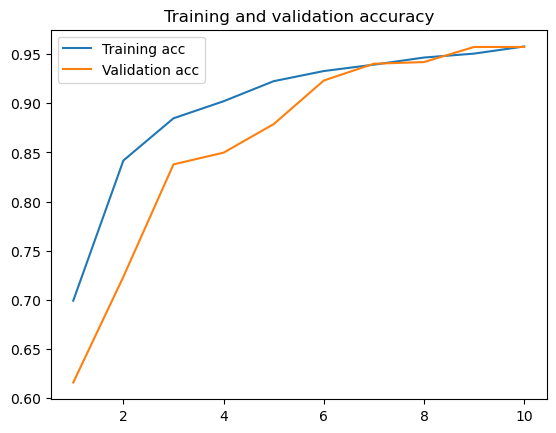

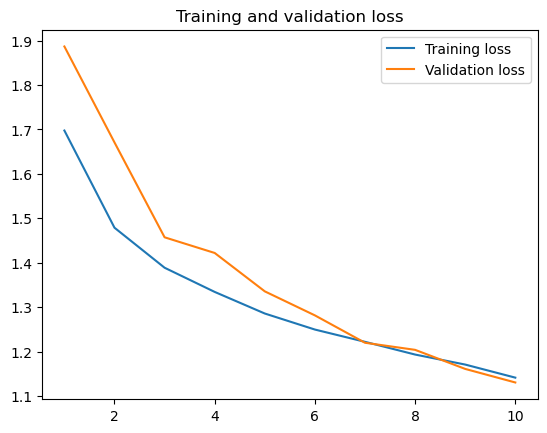

47/47 [==============================] - 5s 79ms/step
Accuracy: 92.58%
Precision: 0.94
Recall: 0.93
F1 Score: 0.93
Confusion Matrix:
[[647 110]
 [  0 726]]


In [73]:
metrics(history)
extra_metrics(model)

In [74]:
from tensorflow.keras.applications import ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling layer
x = Flatten()(x)  # Necessary Flattening Layer
# Add a Dense layer with L2 regularization and Dropout
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)  # Fully connected layer with L2 regularization
x = Dropout(0.5)(x)  
predictions = Dense(len(labels), activation='softmax')(x)  # Output layer

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model (fine-tuning)
for layer in base_model.layers[:-15]:
    layer.trainable = False
for layer in base_model.layers[-15:]:
    layer.trainable = True

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [76]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=10, min_lr=1e-7, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_resnet50.h5', monitor='val_loss', save_best_only=True, verbose=1)

batch_size = 32
epochs = 10

# Assuming datagen, x_train, y_train, x_test, y_test are already defined
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train) // batch_size,
                    validation_data=(x_val, y_val),
                    callbacks=[reduce_lr, early_stopping, model_checkpoint],
                    epochs=epochs)

Epoch 1/10
164/164 [==============================] - ETA: 0s - loss: 1.0783 - accuracy: 0.8624
Epoch 1: val_loss improved from inf to 0.82114, saving model to best_model_resnet50.h5
164/164 [==============================] - 86s 524ms/step - loss: 1.0783 - accuracy: 0.8624 - val_loss: 0.8211 - val_accuracy: 0.9528 - lr: 1.0000e-04
Epoch 2/10
164/164 [==============================] - ETA: 0s - loss: 0.8987 - accuracy: 0.8798
Epoch 2: val_loss did not improve from 0.82114
164/164 [==============================] - 88s 534ms/step - loss: 0.8987 - accuracy: 0.8798 - val_loss: 1.0008 - val_accuracy: 0.7761 - lr: 1.0000e-04
Epoch 3/10
164/164 [==============================] - ETA: 0s - loss: 0.7969 - accuracy: 0.8878
Epoch 3: val_loss did not improve from 0.82114
164/164 [==============================] - 87s 530ms/step - loss: 0.7969 - accuracy: 0.8878 - val_loss: 2.1253 - val_accuracy: 0.5145 - lr: 1.0000e-04
Epoch 4/10
164/164 [==============================] - ETA: 0s - loss: 0.7311 -

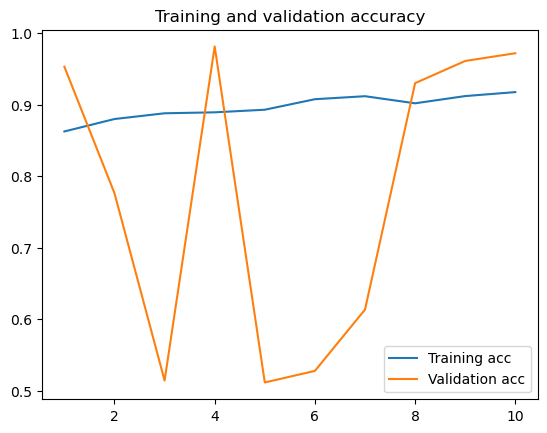

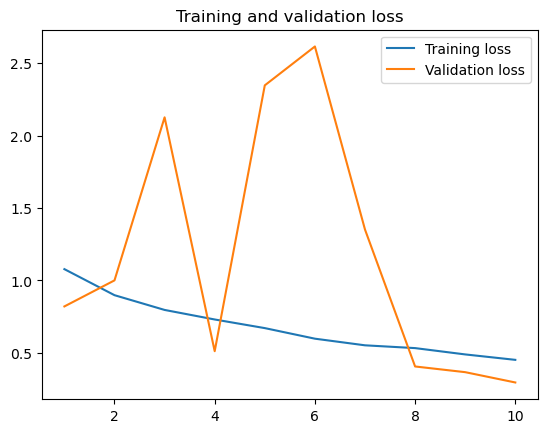

47/47 [==============================] - 18s 356ms/step
Accuracy: 97.17%
Precision: 0.97
Recall: 0.97
F1 Score: 0.97
Confusion Matrix:
[[754   3]
 [ 39 687]]


In [77]:
metrics(history)
extra_metrics(model)

In [78]:
from tensorflow.keras.applications import Xception
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling layer
x = Flatten()(x)  # Necessary Flattening Layer
# Add a Dense layer with L2 regularization and Dropout
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)  # Fully connected layer with L2 regularization
x = Dropout(0.5)(x)  
predictions = Dense(len(labels), activation='softmax')(x)  # Output layer

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model (fine-tuning)
for layer in base_model.layers[:-15]:
    layer.trainable = False
for layer in base_model.layers[-15:]:
    layer.trainable = True

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [79]:
# Additional callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=10, min_lr=1e-7, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_xception_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

batch_size = 32
epochs = 10

# Fit the model with the defined callbacks
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train) // batch_size,
                    validation_data=(x_val, y_val),
                    callbacks=[reduce_lr, early_stopping, model_checkpoint],
                    epochs=epochs)

Epoch 1/10
164/164 [==============================] - ETA: 0s - loss: 1.9075 - accuracy: 0.7352
Epoch 1: val_loss improved from inf to 1.66081, saving model to best_xception_model.h5


C:\Users\KamalM12\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


164/164 [==============================] - 90s 510ms/step - loss: 1.9075 - accuracy: 0.7352 - val_loss: 1.6608 - val_accuracy: 0.8481 - lr: 1.0000e-05
Epoch 2/10
164/164 [==============================] - ETA: 0s - loss: 1.6582 - accuracy: 0.8609
Epoch 2: val_loss improved from 1.66081 to 1.53498, saving model to best_xception_model.h5
164/164 [==============================] - 76s 460ms/step - loss: 1.6582 - accuracy: 0.8609 - val_loss: 1.5350 - val_accuracy: 0.8908 - lr: 1.0000e-05
Epoch 3/10
164/164 [==============================] - ETA: 0s - loss: 1.5338 - accuracy: 0.8991
Epoch 3: val_loss improved from 1.53498 to 1.45524, saving model to best_xception_model.h5
164/164 [==============================] - 82s 498ms/step - loss: 1.5338 - accuracy: 0.8991 - val_loss: 1.4552 - val_accuracy: 0.9215 - lr: 1.0000e-05
Epoch 4/10
164/164 [==============================] - ETA: 0s - loss: 1.4595 - accuracy: 0.9170
Epoch 4: val_loss improved from 1.45524 to 1.39675, saving model to best_xcep

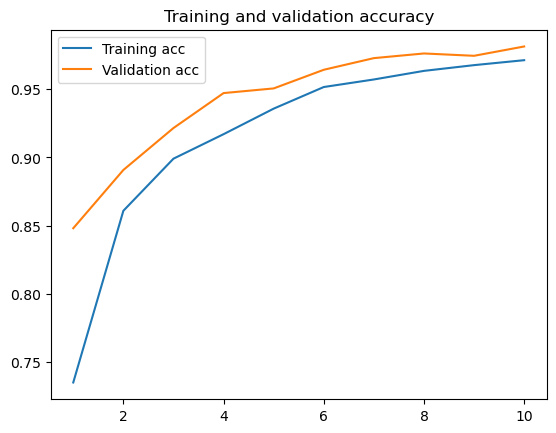

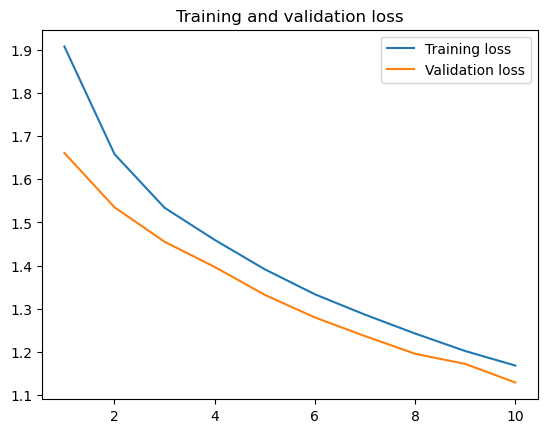

47/47 [==============================] - 15s 304ms/step
Accuracy: 96.70%
Precision: 0.97
Recall: 0.97
F1 Score: 0.97
Confusion Matrix:
[[713  44]
 [  5 721]]


In [80]:
metrics(history)
extra_metrics(model)

In [90]:
from tensorflow.keras.applications import InceptionResNetV2
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling layer
x = Flatten()(x)  # Necessary Flattening Layer
# Add a Dense layer with L2 regularization and Dropout
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)  # Fully connected layer with L2 regularization
x = Dropout(0.5)(x)  
predictions = Dense(len(labels), activation='softmax')(x)  # Output layer

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model (fine-tuning)
for layer in base_model.layers[:-15]:
    layer.trainable = False
for layer in base_model.layers[-15:]:
    layer.trainable = True

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

219055592/219055592 [==============================] - 66s 0us/step


In [91]:
# Additional callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=10, min_lr=1e-7, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_inception_res.h5', monitor='val_loss', save_best_only=True, verbose=1)

batch_size = 32
epochs = 10

# Fit the model with the defined callbacks
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train) // batch_size,
                    validation_data=(x_val, y_val),
                    callbacks=[reduce_lr, early_stopping, model_checkpoint],
                    epochs=epochs)

Epoch 1/10
164/164 [==============================] - ETA: 0s - loss: 1.6694 - accuracy: 0.7865
Epoch 1: val_loss improved from inf to 1.55856, saving model to best_inception_res.h5


C:\Users\KamalM12\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


164/164 [==============================] - 94s 503ms/step - loss: 1.6694 - accuracy: 0.7865 - val_loss: 1.5586 - val_accuracy: 0.8481 - lr: 1.0000e-05
Epoch 2/10
164/164 [==============================] - ETA: 0s - loss: 1.5209 - accuracy: 0.8620
Epoch 2: val_loss improved from 1.55856 to 1.43554, saving model to best_inception_res.h5
164/164 [==============================] - 77s 466ms/step - loss: 1.5209 - accuracy: 0.8620 - val_loss: 1.4355 - val_accuracy: 0.8942 - lr: 1.0000e-05
Epoch 3/10
164/164 [==============================] - ETA: 0s - loss: 1.4512 - accuracy: 0.8893
Epoch 3: val_loss improved from 1.43554 to 1.38240, saving model to best_inception_res.h5
164/164 [==============================] - 76s 462ms/step - loss: 1.4512 - accuracy: 0.8893 - val_loss: 1.3824 - val_accuracy: 0.9181 - lr: 1.0000e-05
Epoch 4/10
164/164 [==============================] - ETA: 0s - loss: 1.3990 - accuracy: 0.9021
Epoch 4: val_loss improved from 1.38240 to 1.33857, saving model to best_incept

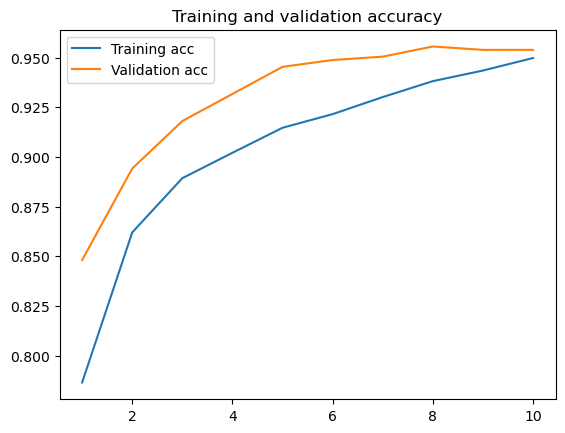

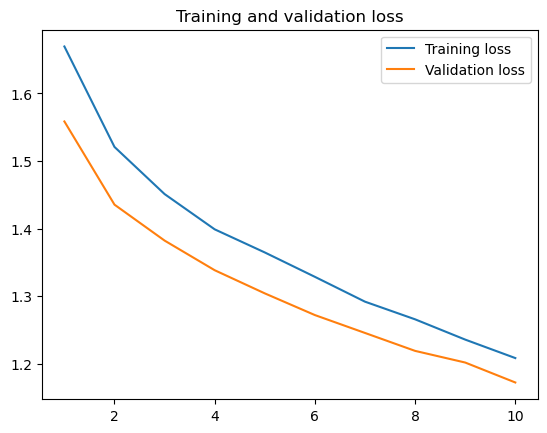

47/47 [==============================] - 21s 376ms/step
Accuracy: 96.90%
Precision: 0.97
Recall: 0.97
F1 Score: 0.97
Confusion Matrix:
[[711  46]
 [  0 726]]


In [92]:
metrics(history)
extra_metrics(model)

In [93]:
from tensorflow.keras.applications import ResNet101V2
base_model = ResNet101V2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling layer
x = Flatten()(x)  # Necessary Flattening Layer
# Add a Dense layer with L2 regularization and Dropout
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)  # Fully connected layer with L2 regularization
x = Dropout(0.5)(x)  
predictions = Dense(len(labels), activation='softmax')(x)  # Output layer

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model (fine-tuning)
for layer in base_model.layers[:-15]:
    layer.trainable = False
for layer in base_model.layers[-15:]:
    layer.trainable = True

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

171317808/171317808 [==============================] - 52s 0us/step


In [94]:
# Additional callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=10, min_lr=1e-7, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_resnet101v2_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

batch_size = 32
epochs = 10

# Fit the model with the defined callbacks
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train) // batch_size,
                    validation_data=(x_val, y_val),
                    callbacks=[reduce_lr, early_stopping, model_checkpoint],
                    epochs=epochs)

Epoch 1/10
164/164 [==============================] - ETA: 0s - loss: 1.8529 - accuracy: 0.7460
Epoch 1: val_loss improved from inf to 1.61574, saving model to best_resnet101v2_model.h5


C:\Users\KamalM12\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


164/164 [==============================] - 127s 732ms/step - loss: 1.8529 - accuracy: 0.7460 - val_loss: 1.6157 - val_accuracy: 0.8720 - lr: 1.0000e-05
Epoch 2/10
164/164 [==============================] - ETA: 0s - loss: 1.6174 - accuracy: 0.8724
Epoch 2: val_loss improved from 1.61574 to 1.51525, saving model to best_resnet101v2_model.h5
164/164 [==============================] - 117s 713ms/step - loss: 1.6174 - accuracy: 0.8724 - val_loss: 1.5152 - val_accuracy: 0.8993 - lr: 1.0000e-05
Epoch 3/10
164/164 [==============================] - ETA: 0s - loss: 1.5196 - accuracy: 0.9004
Epoch 3: val_loss improved from 1.51525 to 1.43503, saving model to best_resnet101v2_model.h5
164/164 [==============================] - 118s 716ms/step - loss: 1.5196 - accuracy: 0.9004 - val_loss: 1.4350 - val_accuracy: 0.9283 - lr: 1.0000e-05
Epoch 4/10
164/164 [==============================] - ETA: 0s - loss: 1.4442 - accuracy: 0.9204
Epoch 4: val_loss improved from 1.43503 to 1.36957, saving model to 

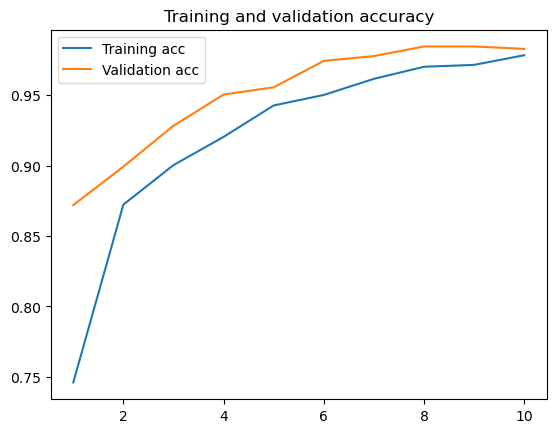

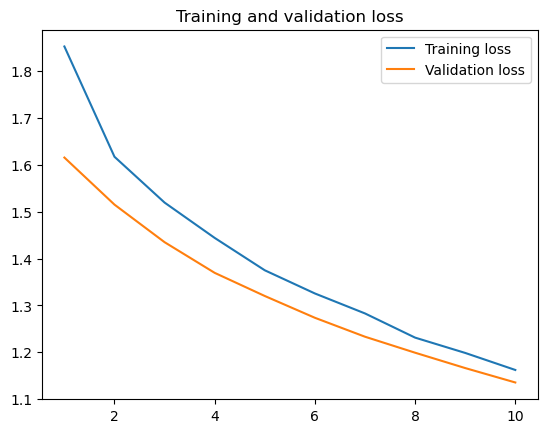

47/47 [==============================] - 27s 538ms/step
Accuracy: 93.39%
Precision: 0.94
Recall: 0.93
F1 Score: 0.93
Confusion Matrix:
[[669  88]
 [ 10 716]]


In [95]:
metrics(history)
extra_metrics(model)

In [99]:
from tensorflow.keras.applications import InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling layer
x = Flatten()(x)  # Necessary Flattening Layer
# Add a Dense layer with L2 regularization and Dropout
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)  # Fully connected layer with L2 regularization
x = Dropout(0.5)(x)  
predictions = Dense(len(labels), activation='softmax')(x)  # Output layer

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model (fine-tuning)
for layer in base_model.layers[:-15]:
    layer.trainable = False
for layer in base_model.layers[-15:]:
    layer.trainable = True

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [100]:
# Additional callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=10, min_lr=1e-7, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_inception_v3_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

batch_size = 32
epochs = 20

# Fit the model with the defined callbacks
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train) // batch_size,
                    validation_data=(x_val, y_val),
                    callbacks=[reduce_lr, early_stopping, model_checkpoint],
                    epochs=epochs)

Epoch 1/20
164/164 [==============================] - ETA: 0s - loss: 1.9076 - accuracy: 0.7077
Epoch 1: val_loss improved from inf to 1.67721, saving model to best_inception_v3_model.h5


C:\Users\KamalM12\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


164/164 [==============================] - 52s 287ms/step - loss: 1.9076 - accuracy: 0.7077 - val_loss: 1.6772 - val_accuracy: 0.8447 - lr: 1.0000e-05
Epoch 2/20
164/164 [==============================] - ETA: 0s - loss: 1.7226 - accuracy: 0.8300
Epoch 2: val_loss improved from 1.67721 to 1.61397, saving model to best_inception_v3_model.h5
164/164 [==============================] - 45s 271ms/step - loss: 1.7226 - accuracy: 0.8300 - val_loss: 1.6140 - val_accuracy: 0.8669 - lr: 1.0000e-05
Epoch 3/20
164/164 [==============================] - ETA: 0s - loss: 1.6518 - accuracy: 0.8508
Epoch 3: val_loss improved from 1.61397 to 1.56351, saving model to best_inception_v3_model.h5
164/164 [==============================] - 45s 272ms/step - loss: 1.6518 - accuracy: 0.8508 - val_loss: 1.5635 - val_accuracy: 0.8874 - lr: 1.0000e-05
Epoch 4/20
164/164 [==============================] - ETA: 0s - loss: 1.6030 - accuracy: 0.8722
Epoch 4: val_loss improved from 1.56351 to 1.52880, saving model to b

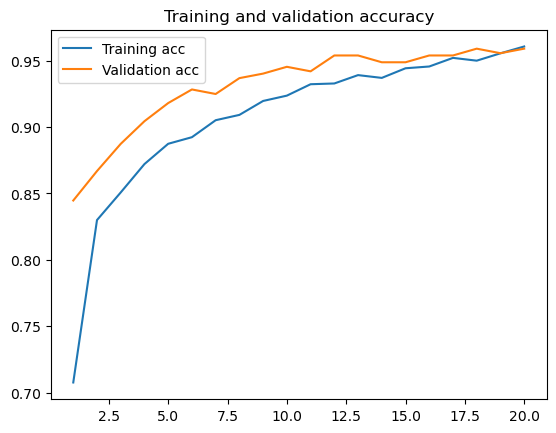

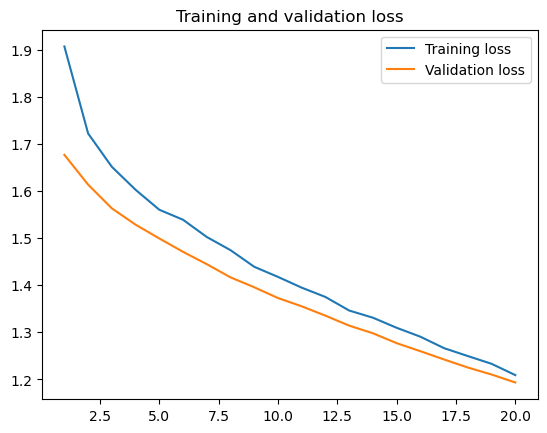

47/47 [==============================] - 8s 144ms/step
Accuracy: 94.07%
Precision: 0.95
Recall: 0.94
F1 Score: 0.94
Confusion Matrix:
[[671  86]
 [  2 724]]


In [101]:
metrics(history)
extra_metrics(model)

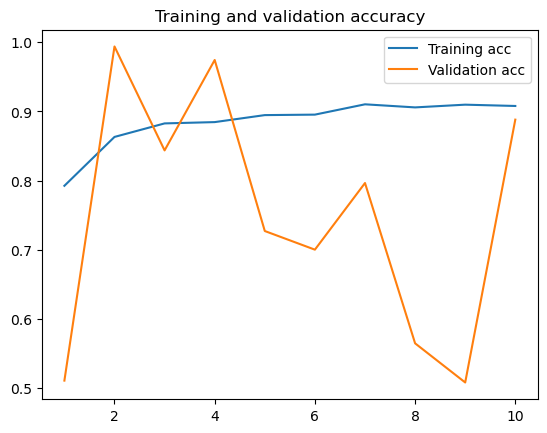

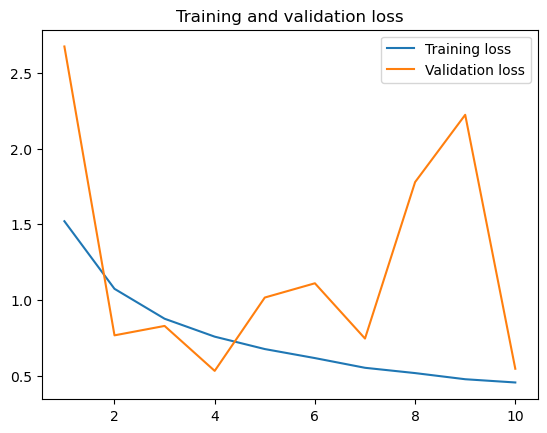

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def extra_metrics(model1):
    predict = model1.predict(x_test)
    predicted_classes = np.argmax(predict, axis=1)
    if y_test.ndim > 1 and y_test.shape[1] > 1:  # Checks if y_test is one-hot encoded
        true_classes = np.argmax(y_test, axis=1)
    else:
        true_classes = y_test
    accuracy = accuracy_score(true_classes, predicted_classes)
    precision = precision_score(true_classes, predicted_classes, average='weighted')
    recall = recall_score(true_classes, predicted_classes, average='weighted')
    f1 = f1_score(true_classes, predicted_classes, average='weighted')



    conf_matrix = confusion_matrix(true_classes, predicted_classes)
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print('Confusion Matrix:')
    print(conf_matrix)
    
def metrics(history1):
    acc = history1.history['accuracy']
    val_acc = history1.history['val_accuracy']
    loss = history1.history['loss']
    val_loss = history1.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, label='Training acc')
    plt.plot(epochs, val_acc, label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [87]:
from tensorflow.keras.applications import DenseNet121
base_model = tf.keras.applications.DenseNet121(
                include_top=False,
                weights="imagenet",
                input_shape=(150,150,3),  # (512, 512, 3),
            )
for layer in base_model.layers:
        layer.trainable = False
    # Unfreeze the Final 4 layers in the base model
for layer in base_model.layers[-4:]:
    layer.trainable = True
# Define custom dense layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation="relu", kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(len(labels), activation="softmax")(x)
# Create the transfer model
transfer_model = Model(inputs=base_model.input, outputs=x)
# Compile the model
transfer_model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=10, min_lr=1e-7, verbose=1)

history = transfer_model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=10,
                    validation_data=(x_val, y_val),
                    callbacks=[reduce_lr])





Epoch 1/10
165/165 [==============================] - 63s 337ms/step - loss: 20.9188 - accuracy: 0.8655 - val_loss: 9.2529 - val_accuracy: 0.9386 - lr: 0.0100
Epoch 2/10
165/165 [==============================] - 53s 319ms/step - loss: 8.5710 - accuracy: 0.8997 - val_loss: 4.6690 - val_accuracy: 0.9573 - lr: 0.0100
Epoch 3/10
165/165 [==============================] - 53s 320ms/step - loss: 3.8554 - accuracy: 0.9133 - val_loss: 5.4110 - val_accuracy: 0.9215 - lr: 0.0100
Epoch 4/10
165/165 [==============================] - 52s 315ms/step - loss: 2.3317 - accuracy: 0.9344 - val_loss: 1.3773 - val_accuracy: 0.9096 - lr: 0.0100
Epoch 5/10
165/165 [==============================] - 51s 309ms/step - loss: 0.9542 - accuracy: 0.9499 - val_loss: 0.6787 - val_accuracy: 0.9539 - lr: 0.0100
Epoch 6/10
165/165 [==============================] - 51s 309ms/step - loss: 0.6245 - accuracy: 0.9516 - val_loss: 0.4581 - val_accuracy: 0.9608 - lr: 0.0100
Epoch 7/10
165/165 [==============================]

In [88]:
model.save('best_densenet_121_model.h5')

C:\Users\KamalM12\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


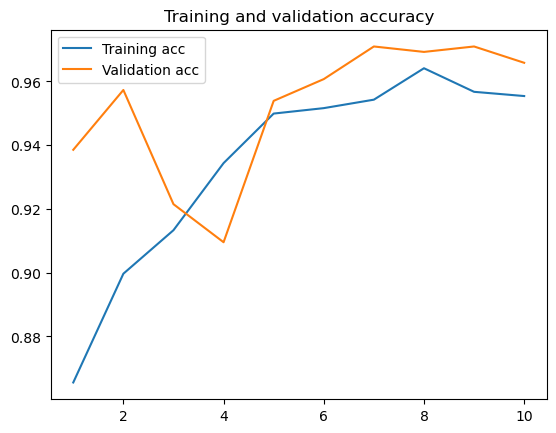

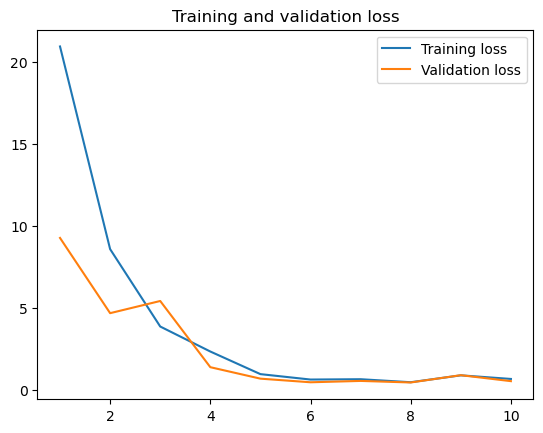

47/47 [==============================] - 14s 261ms/step
Accuracy: 92.04%
Precision: 0.93
Recall: 0.92
F1 Score: 0.92
Confusion Matrix:
[[639 118]
 [  0 726]]


In [89]:
metrics(history)
extra_metrics(transfer_model)